# KLC



# Dependencies and Data Loading

In [295]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [296]:
import random 
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from numpy.linalg import *
from math import floor

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm.notebook import tqdm, trange

from torchvision import models
from torchvision.transforms import RandomErasing
from torchsummary import summary

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from math import prod

import cv2
import plotly.graph_objects as go
import numpy as np
import plotly.express as px
from pylab import rcParams

from scipy.ndimage.interpolation import shift

In [297]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.get_num_threads()

(device(type='cuda'), 1)

## Data Structures

In [298]:
class PassBlockDataset(Dataset):
  def __init__(self, data=None, labels=None, truncate=False, samples=1, scale=1):

    if data is None:
      self.df = pd.read_csv('/content/drive/MyDrive/big data bowl/playtensor.csv')
      self.labels = pd.read_csv('/content/drive/MyDrive/big data bowl/uid_labels.csv')
    else: 
      self.df = data
      self.labels = labels

    # self.xdim = max(self.df.x)+1
    # self.ydim = max(self.df.y)+1
    # self.tdim = max(self.df.t)+1

    self.xdim = 368
    self.ydim = 560
    self.tdim = 112

    self.samples = samples
    self.nplays = len(self.labels)

    self.truncate = truncate
    self.scale = scale

    self.maxtimes = np.random.randint(0, np.tile(self.labels.maxtime, self.samples))   

  def __len__(self):
    return self.nplays * self.samples
    
  def __getitem__(self, idx):   
    if idx >= self.nplays:
      new_idx =  idx % self.nplays
    else:
      new_idx = idx

    current_uid = self.labels.iloc[new_idx].uid
    playdata = self.df.query('uid == @current_uid')

    label = self.labels.iloc[new_idx].clean

    if self.truncate:
      new_maxtime = self.maxtimes[idx]
      playdata = playdata.query('t <= @new_maxtime')

    play = torch.zeros(2, self.xdim, self.ydim, self.tdim).to(device)
    # play = torch.zeros(2, 368, 560, 112, dtype=torch.float16).to(device)
        
    for index, row in playdata.iterrows():
      cx = row['x']
      cy = row['y']
      ct = row['t']
      
      co = row['offense']
      cp = row['pass_or_def']
      play[0][cx][cy][ct] = co
      play[1][cx][cy][ct] = cp

    play = nn.functional.interpolate(play, scale_factor = self.scale)

    # for the two channels (a,b), each voxel is encoded such that
    # (offense , passer or rusher) - pff_role 
    # (0,0) - no player
    # (0,1) - pass rush
    # (1,0) - pass block
    # (1,1) - pass

    return play, label, current_uid




class PassBlockPlay(Dataset):
  def __init__(self, data=None, labels=None, scale_factor=1):

    self.df = data
    
    self.maxtime = int(labels.maxtime)
    self.clean = int(labels.clean)
    self.uid = int(labels.uid)

    self.xdim = max(self.df.x)+1
    self.ydim = max(self.df.y)+1
    self.tdim = max(self.df.t)+1

    self.scale = scale_factor
    
  def __len__(self):
    return int(self.maxtime)+1
    
  def __getitem__(self, idx):

    playdata = self.df.query('t <= @idx')
    play = torch.zeros(2, self.xdim, self.ydim, self.tdim).to(device)
        
    for index, row in playdata.iterrows():
      cx = row['x']
      cy = row['y']
      ct = row['t']
      
      co = row['offense']
      cp = row['pass_or_def']
      play[0][cx][cy][ct] = co
      play[1][cx][cy][ct] = cp

      ## TODO seems like we should use sparse tensor
      ## but idk how
      # outplay = play.to_sparse() ???

      # for the two channels (a,b), each voxel is encoded such that
      # (offense , passer or rusher) - pff_role 
      # (0,0) - no player
      # (0,1) - pass rush
      # (1,0) - pass block
      # (1,1) - pass

    label = self.clean
    play = nn.functional.interpolate(play, scale_factor = self.scale)
    return play, label, self.uid



## CNN Architecture

In [299]:
# 325x503x92
# 66x99x92

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    
    self.conv1 = nn.Conv3d(in_channels=2, out_channels=16, kernel_size=10, stride=5, padding = (1,1,1))
    self.bn1 = nn.BatchNorm3d(16)
    self.pool1 = nn.AdaptiveMaxPool3d(output_size = (32,48,48))
  
    self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=5, stride=3, padding = (1,1,1))
    self.bn2 = nn.BatchNorm3d(32)
    self.pool2 = nn.AdaptiveMaxPool3d(output_size = (16,24,24))
    
    self.conv3 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding = (0,0,0))
    self.bn3 = nn.BatchNorm3d(64)
    self.pool3 = nn.AdaptiveMaxPool3d(output_size = (4,6,6))
    
    self.dropout25 = nn.Dropout(0.25)
    self.dropout50 = nn.Dropout(0.50)
    
    self.fc1 = nn.Linear(9216, 32)
    self.fc2 = nn.Linear(32, 2)
    
  def forward(self, x):
      x = self.conv1(x)
      x = self.bn1(x)
      x = F.relu(x)
      x = self.pool1(x)
      x = self.dropout25(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x = F.relu(x)
      x = self.pool2(x)
      x = self.dropout25(x)
      x = self.conv3(x)
      x = self.bn3(x)
      x = F.relu(x)
      x = self.pool3(x)
      x = self.dropout25(x)
      x = torch.flatten(x, 1)
      x = self.fc1(x)
      x = F.relu(x)
      x = self.dropout50(x)
      x = self.fc2(x)
      x = F.softmax(x, dim=1)
      return x

## Data Loading

In [335]:
# training parameters
truncate = False
samples = 1
batch_size = 1
scale = 0.75

df = pd.read_csv('/content/drive/MyDrive/big data bowl/playtensor.csv')
labels = pd.read_csv('/content/drive/MyDrive/big data bowl/uid_labels.csv')

train_uid, validation_uid = train_test_split(labels.uid, test_size=0.3, random_state=4133)
validation_uid, test_uid = train_test_split(validation_uid, test_size=0.3, random_state=4133)

train_df = df[df['uid'].isin(train_uid)]
validation_df = df[df['uid'].isin(validation_uid)]
test_df = df[df['uid'].isin(test_uid)]

train_labels = labels[labels['uid'].isin(train_uid)]
validation_labels = labels[labels['uid'].isin(validation_uid)]
test_labels = labels[labels['uid'].isin(test_uid)]

train_ds = PassBlockDataset(train_df, train_labels, truncate=truncate, samples=samples, scale=scale)
val_ds = PassBlockDataset(validation_df, validation_labels, truncate=truncate, samples=samples, scale=scale)
test_ds = PassBlockDataset(test_df, test_labels, truncate=truncate, samples=samples, scale=scale)

train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size = batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size = batch_size, shuffle=True, num_workers=0)

## 2D & 3D Plot Functions

In [301]:
def playplot_2d(current_play_df):
  rcParams['figure.figsize'] = 10,10
  rcParams['figure.dpi'] = 128

  # plt.style.use('dark_background')

  current_play_df.assign(color = 2*current_play_df.clean - 1)
  current_play_df = current_play_df.assign(opac = 1-round(abs(current_play_df.clean-current_play_df.dirty), 2))
  current_play_df['opac'] = current_play_df['opac'].fillna(0)

  offense = current_play_df.query('offense == 1 & pass_or_def != 1')
  defense = current_play_df.query('offense != 1')
  qb = current_play_df.query('offense == 1 & pass_or_def == 1')

  plt.scatter(x=offense.x, y=offense.y, c=offense.clean, cmap='Blues', label='offense')
  plt.clim(-1,1)
  plt.scatter(x=defense.x, y=defense.y, c=defense.clean, cmap='Reds', label='defense')
  plt.clim(-1,1)
  plt.scatter(x=qb.x, y=qb.y, c=qb.clean, cmap='cool', label='qb')
  plt.clim(-1,1)

  for i, txt in enumerate(current_play_df.point_label):
    plt.annotate(txt, (current_play_df.x[i], current_play_df.y[i]))

  # plt.legend(loc="upper left")
  plt.show()

def playplot_3d(current_play_df):
  import plotly.graph_objs as go

  # fig = px.scatter_3d(current_play_df,
  fig = go.Scatter3d(
      x=current_play_df.x,
      y=current_play_df.y,
      z=current_play_df.t,
      mode = 'markers',
      # text = current_play_df.point_label,
      text = current_play_df.displayName,
                        textposition='top right',
                  textfont=dict(color='#E58606'),
      marker = dict(size=5,
                    color=['rgba({}, {}, {}, {})'.format(r,g,b,a) for r,g,b,a in zip(255*current_play_df.pass_or_def, [0]*len(current_play_df), 255*current_play_df.offense, [1]*len(current_play_df))]  #current_play_df.opac)])
      ))



  data = [fig]

  layout = go.Layout(margin=dict(l=0,
                                r=0,
                                b=0,
                                t=0))

  fig = go.Figure(data=data, layout=layout)

  fig.update_layout(
      autosize=False,
      width=1000,
      height=800,)

  fig.show()

# Team Grading

## Play Cleanliness

interesting uids

4369 really good correlation between play and estimate over time

1919 eagles sack   https://www.philadelphiaeagles.com/video/highlight-dt-javon-hargrave-collapses-pocket-to-sack-mahomes

2186 network does great


In [302]:
# random uid
# i = np.random.randint(len(test_ds)) 

# specific UID
# uid = 1919
# uid = 4369    

# clean or dirty uid
# uid = int(test_labels.query('clean == 0').sample(n=1).uid) #dirty
uid = int(test_labels.query('clean == 1').sample(n=1).uid) #clean

# not used with random uid
i = int(np.where(test_ds.labels.uid == uid)[0])

play, label, uid = test_ds[i] 

current_play_uid = uid
current_play_df = test_df.query('uid == @current_play_uid')
current_play_labels = test_labels.query('uid == @current_play_uid')

current_gameId = int(current_play_labels.gameId)
current_playId = int(current_play_labels.playId)

pff = pd.read_csv('/content/drive/MyDrive/big data bowl/pffScoutingData.csv')

pff_player = pff.query('gameId == @current_gameId & playId == @current_playId')


In [303]:
current_player = int(pff_player.query('pff_role in ["Pass Block", "Pass Rush"]').nflId.sample())
current_role = pff_player.query('nflId == @current_player').pff_role.iloc[0]
current_play = PassBlockPlay(current_play_df, current_play_labels, scale_factor=0.75)
current_play_loader = DataLoader(current_play, batch_size=int(current_play_labels.maxtime), num_workers=0, shuffle=False)

In [304]:
net = CNN().to(device)
# net.load_state_dict(torch.load('/content/drive/MyDrive/big data bowl/cnn_feanor_augmented_4epoch.pt'))
# net.load_state_dict(torch.load('/content/drive/MyDrive/big data bowl/cnn_feanor_fullplay_8.pt'))
net.load_state_dict(torch.load('/content/drive/MyDrive/big data bowl/cnn_feanor_4.pt'))
# net = medcam.inject(net, output_dir="attention_maps", save_maps=True, replace=True, layer=current_layer)

<All keys matched successfully>

In [305]:
expanded_play, expanded_pred, _ = next(iter(current_play_loader)) # should only be one play

net.eval()
with torch.no_grad():
  pred=net(expanded_play).cpu()

In [306]:
pred_df = pd.DataFrame(pred.numpy())
pred_df.columns = ['dirty', 'clean']
pred_df = pred_df.assign(t=range(len(pred_df)))

In [307]:
current_play_df = current_play_df.merge(pred_df, on='t', how='left')

In [308]:
players = pd.read_csv('/content/drive/MyDrive/big data bowl/players.csv')
current_play_df = current_play_df.merge(players, on='nflId', how='left')
current_play_df = current_play_df.assign(point_label = np.where(current_play_df.t == 0, current_play_df.displayName, ''))

In [309]:
current_play_labels

,gameId,playId,uid,maxtime,clean
1182,2021092602,2361,1182,40,1


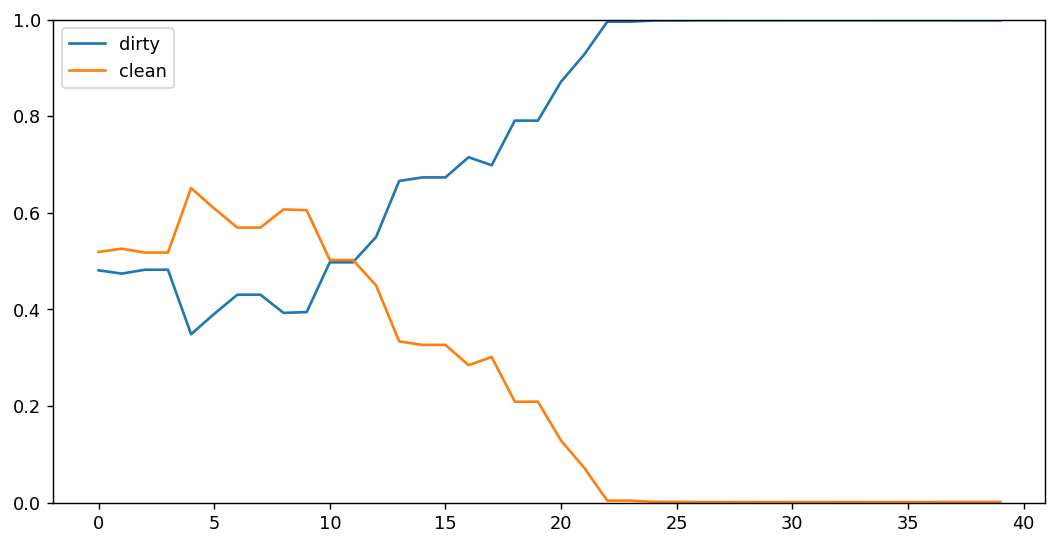

In [310]:
rcParams['figure.figsize'] = 10,5
rcParams['figure.dpi'] = 128

plt.plot(pred[:,0], label='dirty')
plt.plot(pred[:,1], label='clean')
plt.legend(loc="upper left")
plt.ylim([0, 1])
plt.show()

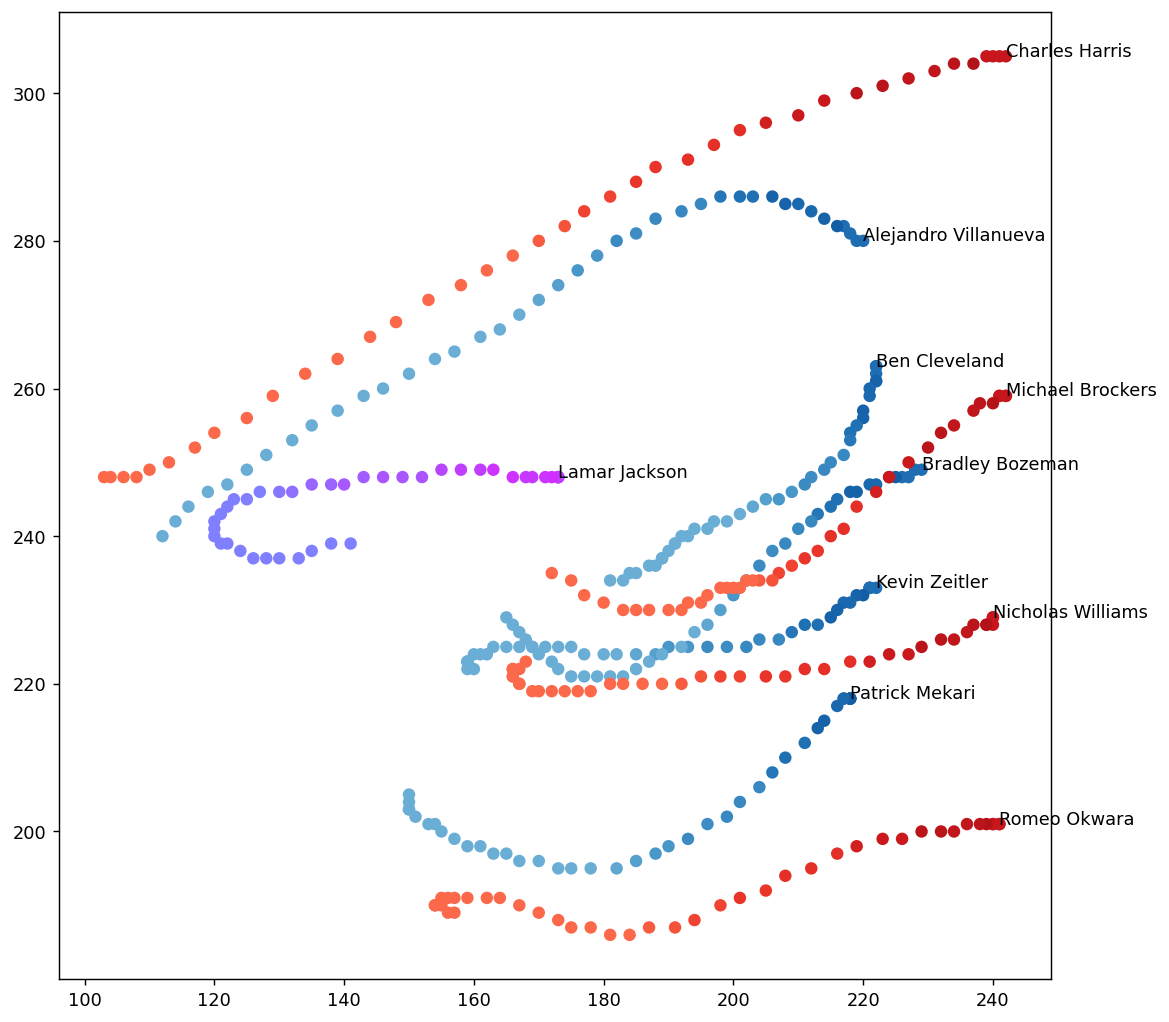

In [311]:
playplot_2d(current_play_df)

In [312]:
playplot_3d(current_play_df)

## Calculate Clean AUC

In [317]:
from IPython.display import clear_output

max_frames = 25

i=0
clean_auc = []

for p in labels.uid:
    i += 1
    clear_output()
    print(str(i) + ' / ' + str(len(labels.uid)) + '\r')
    current_play_uid =  p
    current_play_df = df.query('uid == @current_play_uid')
    current_play_labels = labels.query('uid == @current_play_uid')
    current_gameId = int(current_play_labels.gameId)
    current_playId = int(current_play_labels.playId)

    current_play = PassBlockPlay(current_play_df, current_play_labels, scale_factor=0.75)
    current_play_loader = DataLoader(current_play, batch_size=int(current_play_labels.maxtime), num_workers=0, shuffle=False)

    expanded_play, expanded_pred, _ = next(iter(current_play_loader)) # should only be one play
    
    if current_play.maxtime < 10:
      clean_auc.append(np.nan)
    else: 
      with torch.no_grad():
        pred=net(expanded_play).cpu()
      pred = pred.numpy()   
      clean_auc.append(pred[:max_frames,1].sum())

8036 / 8036


In [336]:
plays = pd.read_csv('/content/drive/MyDrive/big data bowl/plays.csv')
out_df = plays[['gameId', 'playId', 'possessionTeam', 'defensiveTeam']]

out_df = labels.merge(out_df, how='left', on=['gameId', 'playId'])

teams = plays['possessionTeam'].unique()
teams = teams.sort()

out_df['clean_auc'] = clean_auc

In [337]:
counts = df.groupby(['uid', 'offense'])['nflId'].nunique().reset_index()

out_df['player_diff'] = counts.groupby('uid')['nflId'].diff().dropna().reset_index()['nflId']

In [338]:
out_df

,gameId,playId,uid,maxtime,clean,possessionTeam,defensiveTeam,clean_auc,player_diff
0,2021090900,137,0,25,1,DAL,TB,7.243693,1.0
1,2021090900,187,1,22,1,DAL,TB,3.738523,2.0
2,2021090900,282,2,32,1,DAL,TB,4.620148,3.0
3,2021090900,349,3,26,0,DAL,TB,5.631509,2.0
4,2021090900,687,4,22,0,DAL,TB,4.761584,1.0
...,...,...,...,...,...,...,...,...,...
8031,2021110100,3955,8031,39,0,NYG,KC,6.441064,2.0
8032,2021110100,4363,8032,37,0,NYG,KC,6.286508,3.0
8033,2021110100,4392,8033,41,0,NYG,KC,6.408317,2.0
8034,2021110100,4411,8034,26,0,NYG,KC,3.756157,2.0


In [339]:
out_df.to_csv('/content/drive/MyDrive/big data bowl/klc.csv')